In [41]:
import glob
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec

# --- select run
run_options = ["site_311_spintuneup_field", "site_411_spintuneup_field"]
thissite = run_options[0]

In [42]:
# --- FUNCTION to preprocess .txt files for consistent delimiters


def preprocess_txt(file_path):
    data = []  # Initialize a list to store the processed data

    # Initialize a flag to determine if we are reading the header
    is_header = True

    # Read the file line by line and process the data
    with open(file_path) as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace
            if is_header:
                # Split the first line into column names
                column_names = re.split(r"\s+", line)
                is_header = False
            else:
                # Split the other lines into data values
                values = re.split(r"\s+", line)
                data.append(values)

    # Create a DataFrame with the processed data and set column names
    df = pd.DataFrame(data, columns=column_names)
    # return
    return df

In [43]:
# --- read in profile data
# profile data have one file per timestep, so we must read each in separately and combine


# where results are stored
resx = "/home/tykukla/SCEPTER/scepter_output"
results_path = os.path.join(resx, thissite)
flx_path, prof_path = os.path.join(results_path, "flx"), os.path.join(
    results_path, "prof"
)

# define file name pattern
fn_pref = ["prof_aq", "prof_aq(ads%cec)"]  #  ["prof_sld(wt%)", "sa", "rate"]
fn_ext = ".txt"

# loop through variables
df = pd.DataFrame()  # initialize empty df to store dat
for var in fn_pref:
    # set pattern
    fn_pattern = f"{var}-*{fn_ext}"
    # get list of filenames
    file_paths = glob.glob(f"{prof_path}/{fn_pattern}")

    # read in data and concatenate
    for file_path in file_paths:
        dfi = preprocess_txt(file_path)
        # apply pd.to_numeric to all columns using the "map" method
        dfi = dfi.map(pd.to_numeric)
        # add var
        dfi["var"] = var
        # combine
        df = pd.concat([df, dfi], ignore_index=True)


# sort by time and depth
df = df.sort_values(by=["var", "time", "z"])
df

,z,ca,k,mg,na,no3,ph,time,var,8.333333333333333218e-03,2.875977527380498613e-05,h
90,0.008333,0.000194,9.678142e-21,9.371944e-21,9.660359e-21,0.000005,7.800816,0.083334,prof_aq,NaN,NaN,NaN
91,0.025000,0.000205,9.954068e-21,9.914313e-21,9.926376e-21,0.000006,7.802888,0.083334,prof_aq,NaN,NaN,NaN
92,0.041667,0.000211,1.010599e-20,1.021900e-20,1.007920e-20,0.000008,7.796590,0.083334,prof_aq,NaN,NaN,NaN
93,0.058333,0.000217,1.023272e-20,1.047691e-20,1.020559e-20,0.000009,7.791163,0.083334,prof_aq,NaN,NaN,NaN
94,0.075000,0.000221,1.033895e-20,1.069558e-20,1.031149e-20,0.000009,7.786661,0.083334,prof_aq,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
924,0.425000,79.020170,1.710509e-16,1.895749e-15,1.361563e-17,-0.000000,NaN,10000.000001,prof_aq(ads%cec),NaN,NaN,20.97983
925,0.441667,79.020170,1.710531e-16,1.896353e-15,1.361563e-17,-0.000000,NaN,10000.000001,prof_aq(ads%cec),NaN,NaN,20.97983
926,0.458333,79.020170,1.710553e-16,1.896843e-15,1.361563e-17,-0.000000,NaN,10000.000001,prof_aq(ads%cec),NaN,NaN,20.97983
927,0.475000,79.020170,1.710573e-16,1.897196e-15,1.361563e-17,-0.000000,NaN,10000.000001,prof_aq(ads%cec),NaN,NaN,20.97983


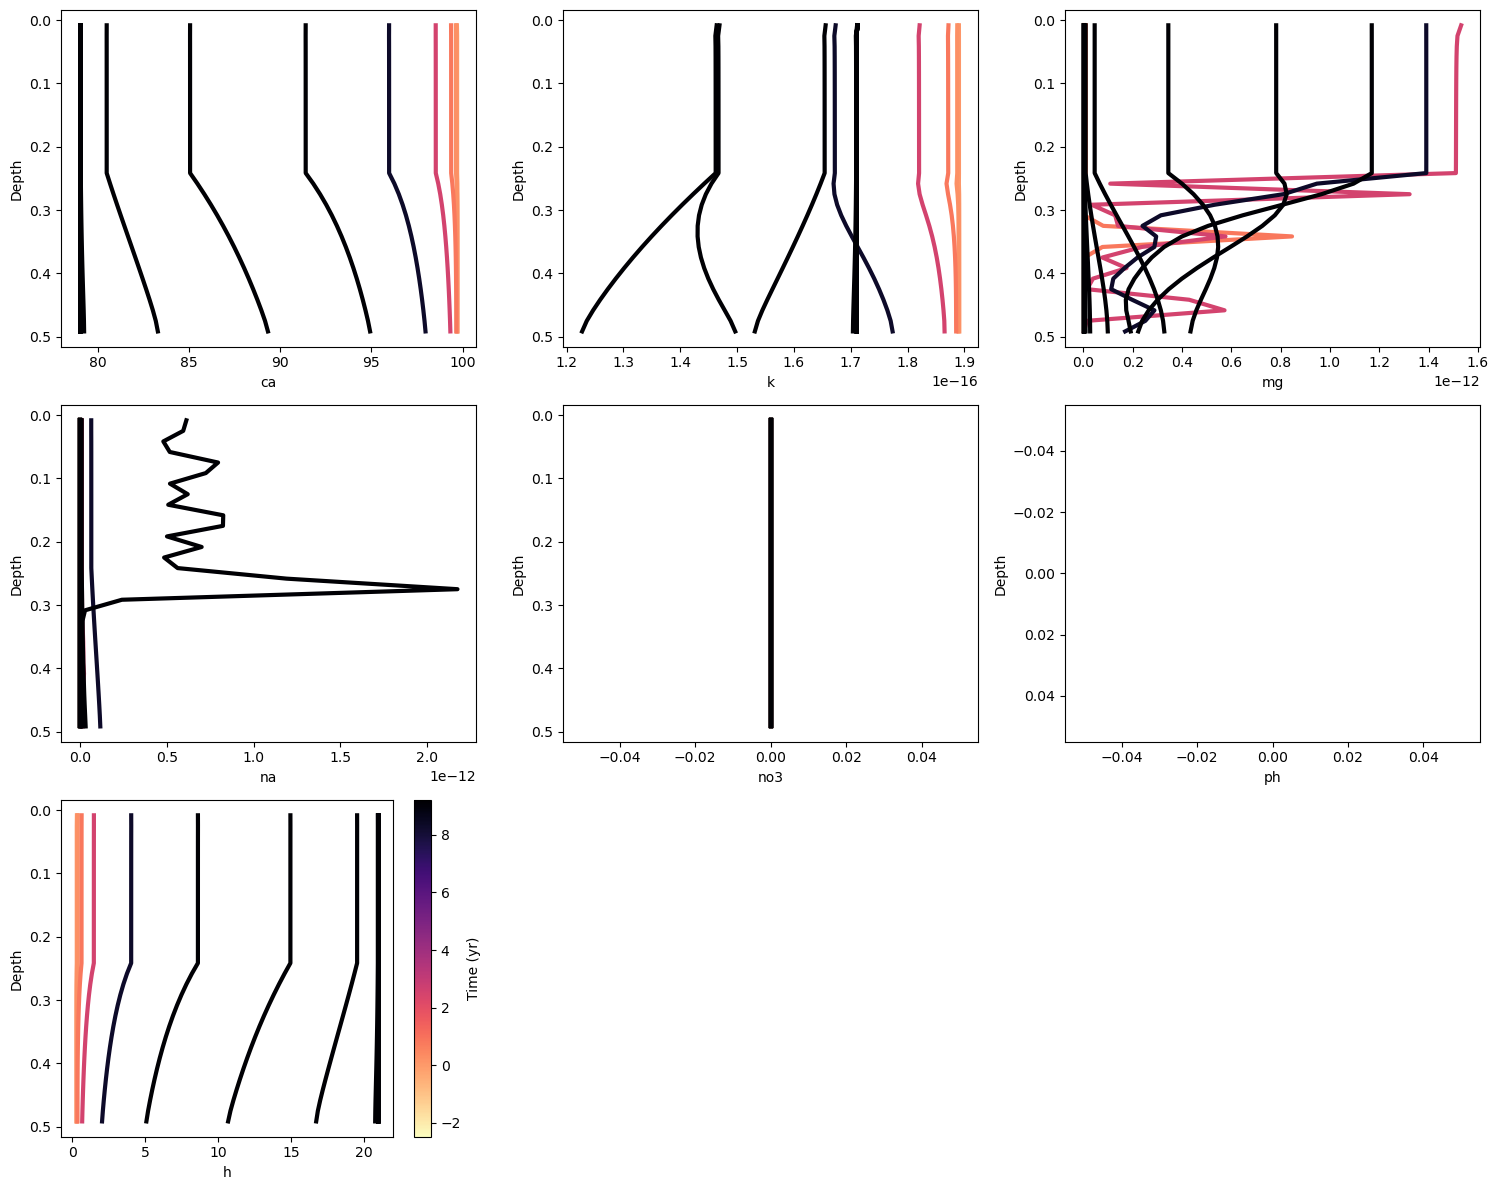

In [45]:
# --- PLOT ALL SPECIES, ONE VAR
this_var = "prof_aq(ads%cec)"  # "prof_aq" # "prof_sld(wt%)" # "sa" # "rate"
log_col = True

dfx = df[df["var"] == this_var]


# Get the list of variables
variables = [
    col
    for col in dfx.columns
    if col
    not in ["z", "time", "var", "8.333333333333333218e-03", "2.875977527380498613e-05"]
]

# group by time
grouped = dfx.groupby("time")

# Calculate number of rows and columns for subplots
num_cols = 3
num_rows = -(-len(variables) // num_cols)  # Round up division

# Create a colormap
cmap = plt.get_cmap("magma")  # Get the colormap
cmap = cmap.reversed()  # flip colormap
# -- no log normalization
if not log_col:
    norm = plt.Normalize(
        df["time"].min(), df["time"].max()
    )  # Normalize time values for colormap
# -- log normalization WIP
else:
    log_time = np.log(df["time"])
    norm = plt.Normalize(
        log_time.min(), log_time.max()
    )  # Normalize time values for colormap

# Create a colorbar based on the Viridis colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)


# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))

# Plot each variable versus depth
for i, var in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    # Create a plot for each time step
    for time, group in grouped:
        color = cmap(norm(time))  # Map time to color using Viridis colormap
        ax.plot(group[var], group["z"], color=color, label=None, linewidth=3)
    ax.set_ylabel("Depth")
    ax.set_xlabel(var)
    # flip y-axis
    # plt.gca().invert_yaxis()
    ax.invert_yaxis()

# Remove empty subplots
for i in range(len(variables), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col] if num_rows > 1 else axes[col])

# add colorbar
sm.set_array([])  # Set an empty array for the colorbar data
cbar = plt.colorbar(sm, label="Time (yr)", ax=plt.gca())

plt.tight_layout()
plt.show()

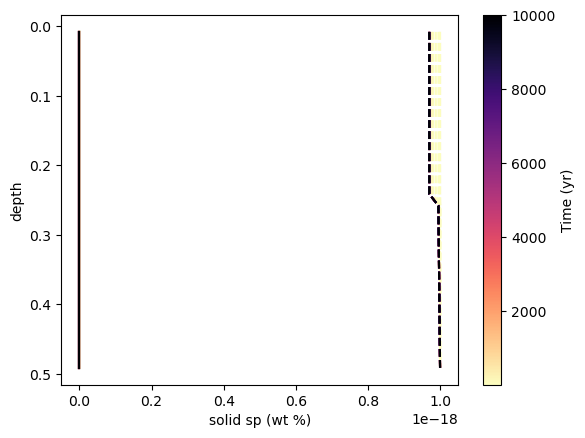

In [5]:
# --- plot depth profile for albite and kaolinite
dfx = df[df["var"] == "prof_sld(wt%)"]
# Group the DataFrame by the 'time' column
grouped = dfx.groupby("time")

# Create a colormap
cmap = plt.get_cmap("magma")  # Get the colormap
cmap = cmap.reversed()  # flip colormap
# -- no log normalization
norm = plt.Normalize(
    df["time"].min(), df["time"].max()
)  # Normalize time values for colormap
# -- log normalization WIP
# log_time = np.log(df['time'])
# norm = plt.Normalize(log_time.min(), log_time.max())  # Normalize time values for colormap

# Create a plot for each time step
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["cc"], group["z"], color=color, label=None)
    plt.plot(group["ka"], group["z"], color=color, linestyle="dashed", label=None)

# Add labels and a legend
plt.xlabel("solid sp (wt %)")
plt.ylabel("depth")

# Create a colorbar based on the Viridis colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty array for the colorbar data
cbar = plt.colorbar(sm, label="Time (yr)", ax=plt.gca())

# flip y-axis
plt.gca().invert_yaxis()

# Show the plot
plt.show()

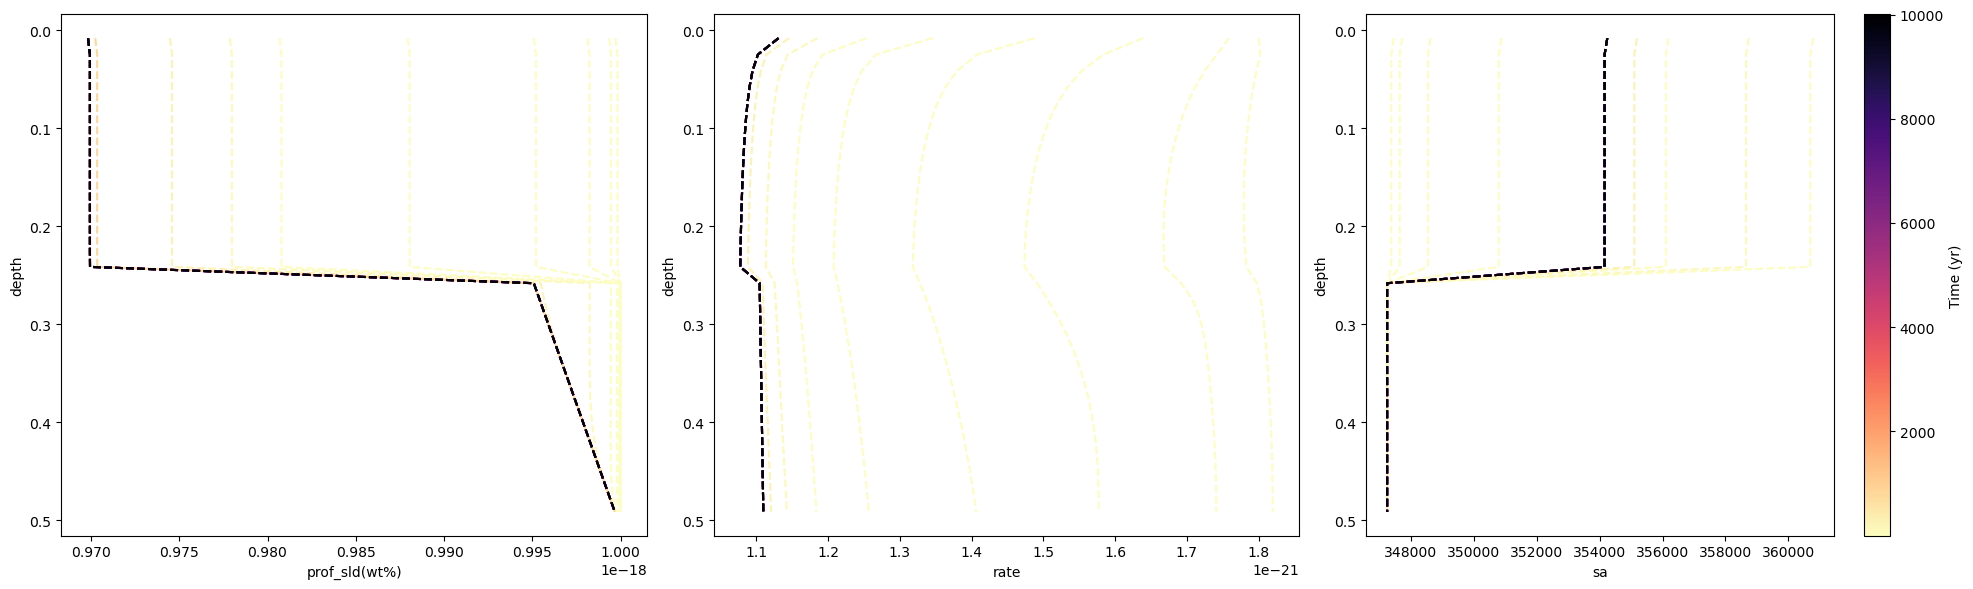

In [7]:
# --- multi-panel plot for all vars
# define number of rows and cols based on unique vars
unique_vars = df["var"].unique()
num_cols = 3
num_rows = (len(unique_vars) + num_cols - 1) // num_cols

# Create a new figure and set up a GridSpec
fig = plt.figure(figsize=(20, 6))  # Adjust figsize as needed
gs = GridSpec(num_rows, num_cols, figure=fig)

for i, var in enumerate(unique_vars):
    # get the row and column indices for the current subplot
    row = i // num_cols
    col = i % num_cols

    # Create a subplot within the GridSpec
    ax = fig.add_subplot(gs[row, col])

    # Filter the DataFrame for the current var
    var_df = df[df["var"] == var]

    # Group the DataFrame by the 'time' column
    grouped = var_df.groupby("time")

    # Create a colormap
    cmap = plt.get_cmap("magma")  # Get the colormap
    cmap = cmap.reversed()  # flip colormap
    # -- no log normalization
    norm = plt.Normalize(
        var_df["time"].min(), var_df["time"].max()
    )  # Normalize time values for colormap
    # -- log normalization WIP
    # log_time = np.log(df['time'])
    # norm = plt.Normalize(log_time.min(), log_time.max())  # Normalize time values for colormap

    # Create a plot for each time step
    for time, group in grouped:
        color = cmap(norm(time))  # Map time to color using Viridis colormap
        # ax.plot(group['ab'], group['z'], color=color, label=None)
        ax.plot(group["ka"], group["z"], color=color, linestyle="dashed", label=None)

    # Add labels and a legend
    ax.set_xlabel(var)
    ax.set_ylabel("depth")

    # Create a colorbar based on the Viridis colormap
    # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # sm.set_array([])  # Set an empty array for the colorbar data
    # cbar = plt.colorbar(sm, label='Time (s)', ax=plt.gca())

    # Add a legend to the last subplot
    if i == len(unique_vars) - 1:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Set an empty array for the colorbar data
        cbar = plt.colorbar(sm, label="Time (yr)", ax=plt.gca())

    # flip y-axis
    plt.gca().invert_yaxis()

# Show the plot
plt.tight_layout()
plt.show()